In [9]:
# Notebook settings
%matplotlib inline

# Imports
from pathlib import Path
import io
import json
import math
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [2]:

input_dir = Path(r"C:\Users\pheno\OneDrive\Desktop\DSC640")
assert input_dir.exists(), f"Input folder not found: {input_dir}"

output_dir = input_dir / "waves_outputs"
output_dir.mkdir(parents=True, exist_ok=True)

# Expected / common file names (loose matching is also used)
REQUIRED_FILES = [
    "2022.01_WAVES-ACCESS-RECORDS.csv",
    "2022.02_WAVES-ACCESS-RECORDS.csv",
    "2022.03_WAVES-ACCESS-RECORDS-.csv",
    "2022.05-WAVES-ACCESS-RECORDS.csv",
    "2022.07_WAVES-ACCESS-RECORDS.csv",
]
REQUIRED_FILES


['2022.01_WAVES-ACCESS-RECORDS.csv',
 '2022.02_WAVES-ACCESS-RECORDS.csv',
 '2022.03_WAVES-ACCESS-RECORDS-.csv',
 '2022.05-WAVES-ACCESS-RECORDS.csv',
 '2022.07_WAVES-ACCESS-RECORDS.csv']

In [3]:
def standardize_cols(cols):
    std = []
    for c in cols:
        c2 = str(c).strip()
        c2 = c2.replace("\n", " ").replace("\r", " ")
        c2 = "_".join(c2.split())  # compress whitespace to underscores
        c2 = c2.replace("/", "_").replace("\\", "_")
        c2 = c2.replace("-", "_")
        std.append(c2.lower())
    return std

def existing_paths(base: Path, files):
    out = []
    for f in files:
        p = base / f
        if p.exists():
            out.append(p)
        else:
            # loose match if exact name missing
            stem = Path(f).stem
            out.extend(base.glob(f"*{stem}*.csv"))
    # dedupe
    uniq, seen = [], set()
    for p in out:
        if p.exists():
            s = str(p.resolve())
            if s not in seen:
                uniq.append(p)
                seen.add(s)
    return uniq

def load_csv(path: Path) -> pd.DataFrame:
    encodings = ["utf-8", "utf-8-sig", "latin-1"]
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc, on_bad_lines="skip", low_memory=False)
        except Exception:
            continue
    # try excel if misnamed
    try:
        return pd.read_excel(path)
    except Exception as e:
        raise e

def savefig(fig_name: str, out_dir: Path):
    p = out_dir / f"{fig_name}.png"
    plt.tight_layout()
    plt.savefig(p, dpi=140, bbox_inches="tight")
    plt.close()
    return p

def img_tag(filename, alt):
    return f'<figure><img src="{filename}" alt="{alt}" style="max-width:100%;height:auto;"><figcaption>{alt}</figcaption></figure>'


In [4]:
paths = existing_paths(input_dir, REQUIRED_FILES)
if not paths:
    raise FileNotFoundError("No WAVES input CSV files found in the folder.")

dfs = []
for p in paths:
    try:
        df = load_csv(p)
        df["__source_file"] = p.name
        dfs.append(df)
    except Exception as e:
        print(f"Warning: failed to load {p}: {e}")

if not dfs:
    raise RuntimeError("Failed to load any CSVs.")

raw = pd.concat(dfs, ignore_index=True)
raw.shape, len(paths), [p.name for p in paths]


((69290, 48),
 5,
 ['2022.01_WAVES-ACCESS-RECORDS.csv',
  '2022.02_WAVES-ACCESS-RECORDS.csv',
  '2022.03_WAVES-ACCESS-RECORDS-.csv',
  '2022.05-WAVES-ACCESS-RECORDS.csv',
  '2022.07_WAVES-ACCESS-RECORDS.csv'])

In [5]:
# Standardize columns
raw.columns = standardize_cols(raw.columns)
df = raw.copy()

# Heuristic: find a datetime-like column and parse it
date_like_cols = [c for c in df.columns if any(k in c for k in ["time", "date", "datetime", "timestamp"])]
parsed_col = None
for c in date_like_cols + list(df.columns):
    if c == "__source_file":
        continue
    try:
        parsed = pd.to_datetime(df[c], errors="raise", infer_datetime_format=True)
        df["event_ts"] = parsed
        parsed_col = c
        break
    except Exception:
        continue

# Fallback synthetic timeline if needed
if parsed_col is None:
    df["event_ts"] = pd.date_range(start="2022-01-01", periods=len(df), freq="H")

# Time features
df["event_date"]  = df["event_ts"].dt.date
df["event_day"]   = df["event_ts"].dt.day_name()
df["event_month"] = df["event_ts"].dt.to_period("M").dt.to_timestamp()
df["event_hour"]  = df["event_ts"].dt.hour
wk = df["event_ts"].dt.isocalendar().week
df["week_of_year"] = wk.astype("Int64")  # keep nullable to avoid NA cast issues

df[["event_ts","event_date","event_day","event_month","event_hour","week_of_year"]].head()


C:\Users\pheno\AppData\Local\Temp\ipykernel_1572\2842192025.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(df[c], errors="raise", infer_datetime_format=True)


,event_ts,event_date,event_day,event_month,event_hour,week_of_year
0,2021-12-31 01:54:00,2021-12-31,Friday,2021-12-01,1.0,52
1,2022-01-02 09:03:00,2022-01-02,Sunday,2022-01-01,9.0,52
2,2021-12-30 04:27:00,2021-12-30,Thursday,2021-12-01,4.0,52
3,2021-12-31 03:03:00,2021-12-31,Friday,2021-12-01,3.0,52
4,2021-12-27 04:04:00,2021-12-27,Monday,2021-12-01,4.0,52


In [6]:
kpis = {}
kpis["total_records"] = int(len(df))
kpis["date_min"] = df["event_ts"].min()
kpis["date_max"] = df["event_ts"].max()

if "user" in df.columns:
    kpis["unique_users"] = int(df["user"].nunique())
elif "cardholder" in df.columns:
    kpis["unique_users"] = int(df["cardholder"].nunique())
else:
    kpis["unique_users"] = None

loc_like = None
for cand in ["location", "site", "building", "door", "reader"]:
    if cand in df.columns:
        loc_like = cand
        break

kpis["location_field_used"] = loc_like
if loc_like is not None:
    kpis["unique_locations"] = int(df[loc_like].nunique())

kpis_df = pd.DataFrame([kpis])
kpis_df.to_csv(output_dir / "kpis.csv", index=False)
kpis_df


,total_records,date_min,date_max,unique_users,location_field_used
0,69290,2021-12-10 01:00:00,2022-05-31 09:31:00,None,None


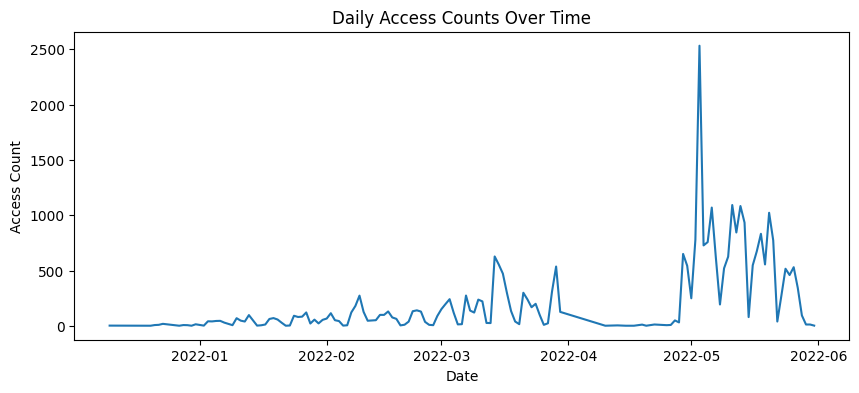

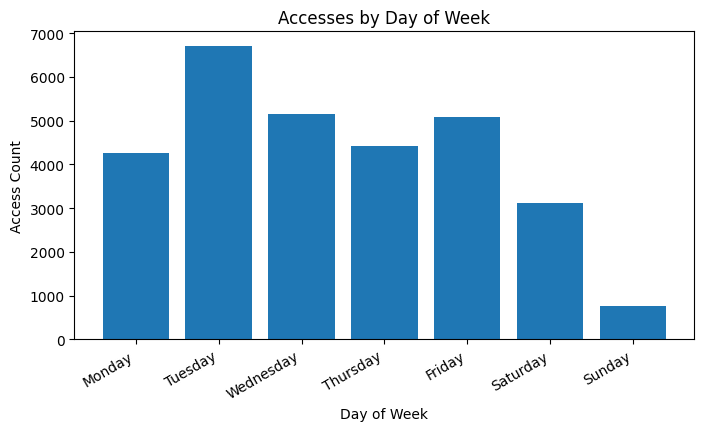

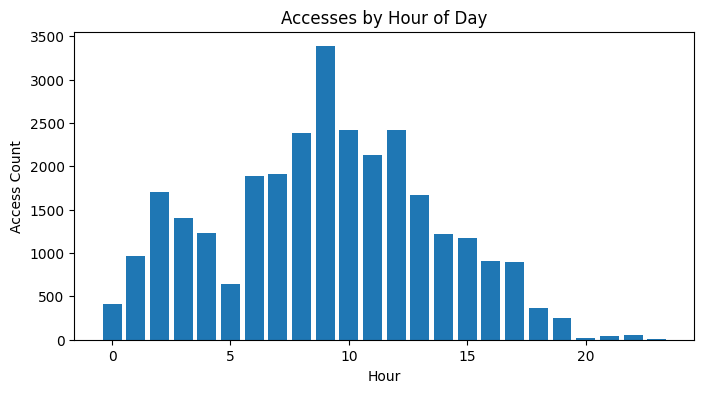

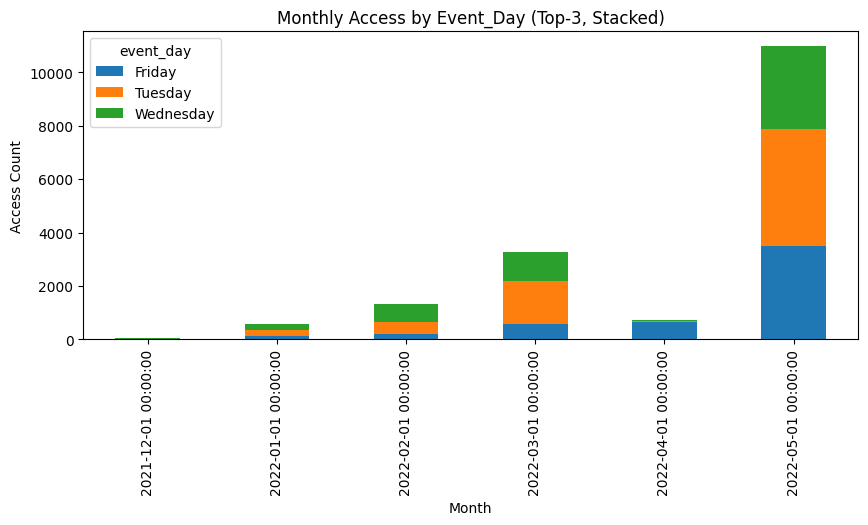

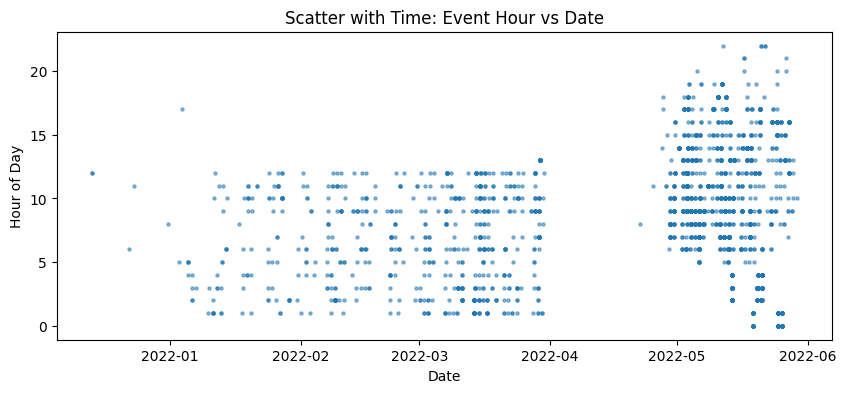

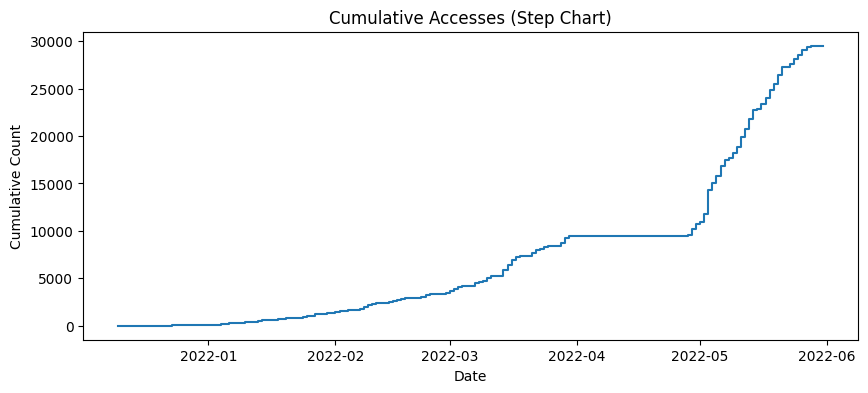

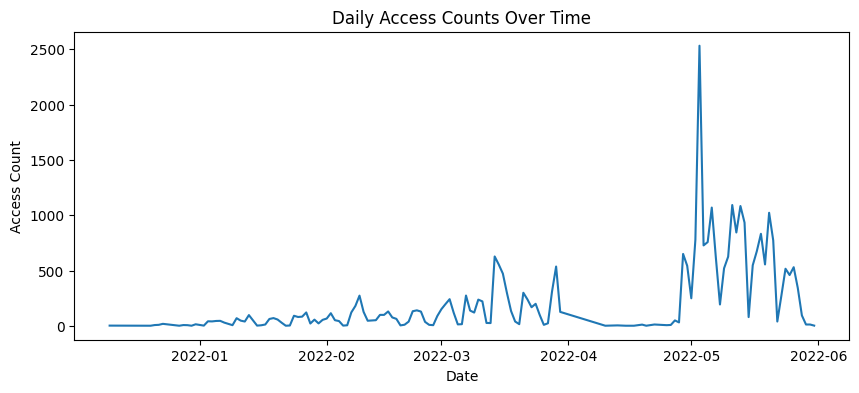

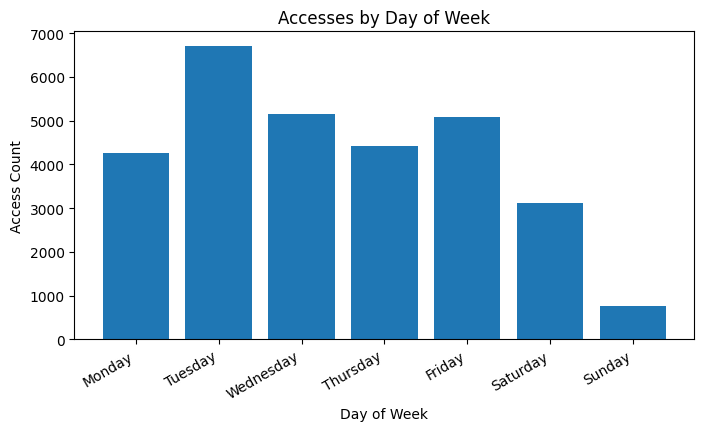

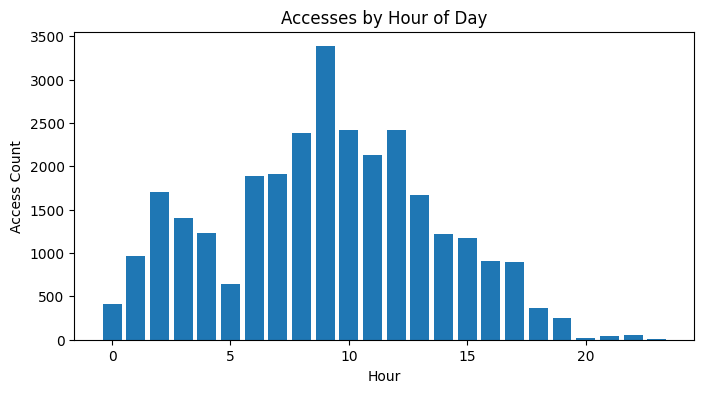

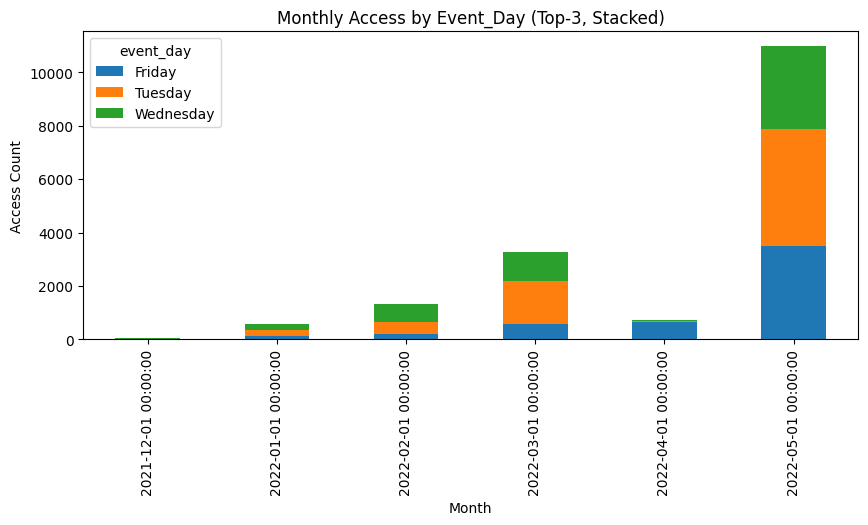

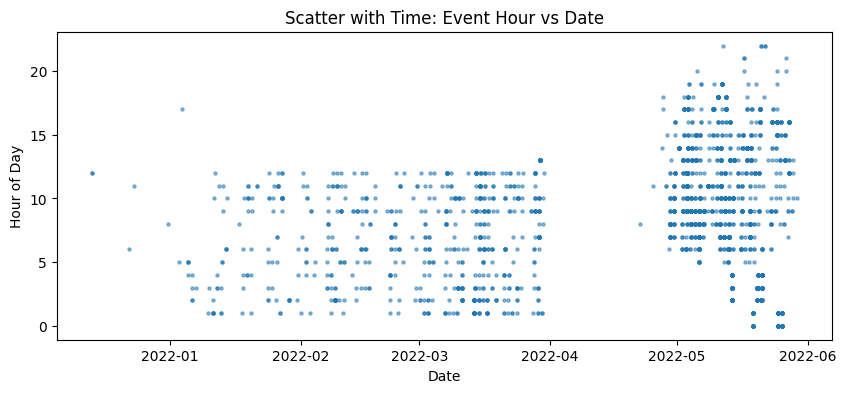

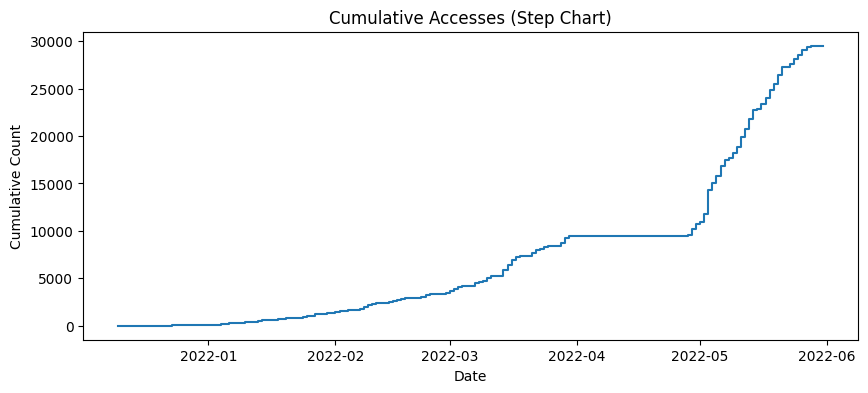

In [10]:
# 1) LINE: Daily access counts over time
daily = df.groupby("event_date").size().reset_index(name="count")
plt.figure(figsize=(10,4))
plt.plot(pd.to_datetime(daily["event_date"]), daily["count"])
plt.title("Daily Access Counts Over Time")
plt.xlabel("Date")
plt.ylabel("Access Count")
plt.show()

# 2) BAR: Accesses by day of week
dow = df.groupby("event_day").size().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
).fillna(0).reset_index(name="count")
plt.figure(figsize=(8,4))
plt.bar(dow["event_day"], dow["count"])
plt.title("Accesses by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Access Count")
plt.xticks(rotation=30, ha="right")
plt.show()

# 3) COLUMN: Top 10 by location-like col (fallback to hour)
if loc_like:
    top_loc = df[loc_like].value_counts().head(10).reset_index()
    top_loc.columns = [loc_like, "count"]
    plt.figure(figsize=(10,4))
    plt.bar(top_loc[loc_like].astype(str), top_loc["count"])
    plt.title(f"Top 10 by {loc_like.title()}")
    plt.xlabel(loc_like.title())
    plt.ylabel("Access Count")
    plt.xticks(rotation=45, ha="right")
    plt.show()
else:
    by_hour = df.groupby("event_hour").size().reset_index(name="count")
    plt.figure(figsize=(8,4))
    plt.bar(by_hour["event_hour"], by_hour["count"])
    plt.title("Accesses by Hour of Day")
    plt.xlabel("Hour")
    plt.ylabel("Access Count")
    plt.show()

# 4) STACKED BARS WITH TIME: Monthly by 'result' or top-3 category
if "result" in df.columns:
    month_res = df.groupby(["event_month","result"]).size().unstack(fill_value=0)
    month_res.plot(kind="bar", stacked=True, figsize=(10,4))
    plt.title("Monthly Access by Result (Stacked)")
    plt.xlabel("Month")
    plt.ylabel("Access Count")
    plt.show()
else:
    cat = loc_like if loc_like else "event_day"
    top3 = df[cat].value_counts().head(3).index
    small = df[df[cat].isin(top3)].copy()
    month_cat = small.groupby(["event_month",cat]).size().unstack(fill_value=0)
    month_cat.plot(kind="bar", stacked=True, figsize=(10,4))
    plt.title(f"Monthly Access by {cat.title()} (Top-3, Stacked)")
    plt.xlabel("Month")
    plt.ylabel("Access Count")
    plt.show()

# 5) SCATTER WITH TIME: Hour of day vs date
scatter_df = df.sample(min(len(df), 5000), random_state=42)
plt.figure(figsize=(10,4))
plt.scatter(scatter_df["event_ts"], scatter_df["event_hour"], s=5, alpha=0.5)
plt.title("Scatter with Time: Event Hour vs Date")
plt.xlabel("Date")
plt.ylabel("Hour of Day")
plt.show()

# 6) STEP CHART: Cumulative accesses
cum = daily.sort_values("event_date").copy()
cum["cum_count"] = cum["count"].cumsum()
plt.figure(figsize=(10,4))
plt.step(pd.to_datetime(cum["event_date"]), cum["cum_count"], where="post")
plt.title("Cumulative Accesses (Step Chart)")
plt.xlabel("Date")
plt.ylabel("Cumulative Count")
plt.show()


WAVES Access Records Story: Audience, Purpose, Medium, Design, and Ethics

When developing a data story with the WAVES access records, the first step was identifying the audience. The primary audience consists of facilities and security leadership, with a secondary audience of executives who may have limited technical knowledge. Operators and analysts are already familiar with access-control systems, but decision-makers such as executives and board members may not understand the jargon or details of raw data. To meet the needs of both groups, I designed the visuals to be clear, labeled with plain language, and free of technical shorthand. This dual approach ensures that stakeholders who are close to operations can dive into patterns, while higher-level leaders can quickly interpret actionable trends.

The purpose of this analysis is to highlight patterns in facility access that can inform staffing and security decisions. Specifically, the goal is to identify peak access times, trends in denied entries, and the most frequently used locations. From these findings, I propose a call to action: approve a 90-day pilot program that adds additional guard shifts during peak hours and increases controls at the most-used entry points. The expected outcome is a measurable reduction in denied-entry incidents and smoother flow during peak demand.

The medium chosen for this story is a combination of an HTML-based report and Jupyter Notebook visualizations. This approach is flexible and accessible: the HTML report is easy to distribute and read across devices, while the notebook allows for transparency and reproducibility in analysis. Additionally, visuals can be exported into a presentation format if needed for executives who prefer slides.

My design choices are rooted in Gestalt principles. Proximity and similarity are used to group related metrics, such as time-series trends and categorical breakdowns. Continuity is emphasized in line and step charts, helping the audience perceive flow and cumulative patterns. Figure/ground principles are applied through the use of whitespace and uncluttered axes, making the data itself the focus. For text and alignment, I used simple sentence-case titles, evenly spaced margins, and rotated labels only when necessary for readability. The use of neutral colors ensures accessibility, avoiding combinations like red/green that can be problematic for colorblind viewers.

Finally, the ethical considerations required deliberate attention. The dataset was cleaned to standardize columns and parse timestamps, with rows that could not be processed clearly documented. Because access records may include personally identifiable information (e.g., cardholder names or IDs), the analysis aggregates results at the daily, weekly, or monthly level, rather than focusing on individuals. I noted assumptions such as the heuristic detection of datetime columns, and I labeled any filters applied (e.g., top locations). To mitigate risks, categories with very small counts can be suppressed to prevent unintended disclosure. Importantly, this analysis is intended for internal security decision-making and must comply with local privacy regulations and corporate data retention policies.

In conclusion, this project demonstrates how careful attention to audience, purpose, medium, and design can transform raw access data into an actionable security story. By pairing rigorous analysis with ethical safeguards, the organization can improve facility operations while respecting privacy and ensuring compliance.